In [6]:
import collections
import numpy as np
import pickle
import torch
from tqdm import tqdm
import wandb

import sys
sys.path.append('../')
import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from python_dict_wrapper import wrap
import torch
import seaborn as sns

import matplotlib

matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(font="Arial", style="ticks")

In [2]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

Found 20225


100%|█████████████████████████████████████████████████████████| 20225/20225 [03:14<00:00, 103.75it/s]


Normalize names.

In [3]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
        
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': friendly_name,
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
df.groupby(['dataset', 'subset_overall']).first()

,,key,family,subset,features,layer,features_layer,report_corr,max_r2,rnorm
dataset,subset_overall,,,,,,,,,
mst,36,I3D_layer00_mst_norm_neutralbg_0,SlowFast,0,i3d,0,i3d_00,0.271957,0.961184,0.282940
mt1,84,I3D_layer00_mt1_norm_neutralbg_0,SlowFast,0,i3d,0,i3d_00,0.035600,1.000000,0.035600
mt2,44,I3D_layer00_mt2_0,SlowFast,0,i3d,0,i3d_00,0.182025,1.000000,0.182025
pvc1,23,I3D_layer00_pvc1-repeats_0,SlowFast,0,i3d,0,i3d_00,0.150142,0.757951,0.198090
pvc4,25,I3D_layer00_pvc4_0,SlowFast,0,i3d,0,i3d_00,0.709660,1.000000,0.709660


# Key measurements table

In [4]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)
    
    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]
    
    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

models = ['slowfast', 'i3d', 'r3d_18', 'r2plus1d_18', 'mc3_18',  'cpc_ucf', 'cpc_airsim', 'gaborpyramid3d_motionless', 'gaborpyramid3d',  'motionnet', 'dorsalnet']
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets].loc[models]
df_s = df_s[datasets].loc[models]
df_z = df_z[datasets].loc[models]
    
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 1)}}}\n\\toprule \n"
the_str += '{} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.replace('_', '\_')]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})"[1:])
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")
                
    the_str += ' & '.join(vals) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{llllll}
\toprule 
{} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
slowfast & \textbf{0.471} (0.034) & .361 (0.042) & .211 (0.018) & .281 (0.015) & .189 (0.044)\\
i3d & \textbf{0.457} (0.036) & \textbf{0.389} (0.046) & .213 (0.018) & .284 (0.015) & .219 (0.044)\\
r3d\_18 & .403 (0.032) & \textbf{0.383} (0.042) & .217 (0.018) & .289 (0.015) & .224 (0.046)\\
r2plus1d\_18 & .428 (0.035) & \textbf{0.382} (0.042) & .215 (0.018) & .282 (0.015) & .226 (0.043)\\
mc3\_18 & .405 (0.034) & \textbf{0.393} (0.045) & .218 (0.018) & .276 (0.014) & .228 (0.045)\\
cpc\_ucf & .271 (0.044) & \textbf{0.394} (0.046) & .214 (0.018) & .241 (0.016) & .190 (0.045)\\
cpc\_airsim & .422 (0.036) & \textbf{0.384} (0.045) & \textbf{0.250} (0.020) & .360 (0.017) & .292 (0.045)\\
gaborpyramid3d\_motionless & .273 (0.035) & .353 (0.038) & .212 (0.018) & .188 (0.014) & .248 (0.045)\\
gaborpyramid3d & .325 (0.036) & \textbf{0.366} (0.037) & \textbf{0.249} (0.019) & .301 (0.015) & .394 (0.054)\\
motionnet &

In [5]:
import scipy.stats
zvals = pd.DataFrame(2*scipy.stats.norm.cdf(df_z))
zvals.columns = df_z.columns
zvals.index = df_z.index
zvals

dataset,pvc1,pvc4,mt1,mt2,mst
features,,,,,
slowfast,1.000000e+00,0.042839,2.454452e-13,1.224500e-10,4.241958e-13
i3d,3.908415e-01,0.790068,5.184715e-13,9.244212e-11,3.033100e-12
r3d_18,3.162239e-07,0.579303,3.222876e-13,2.376626e-10,7.643212e-12
r2plus1d_18,6.565309e-03,0.516364,9.529341e-13,4.831973e-11,1.170246e-12
mc3_18,1.487278e-05,0.940749,1.520278e-12,1.084984e-11,1.240219e-12
cpc_ucf,1.793635e-08,1.000000,1.427504e-13,5.290431e-19,3.959816e-16
cpc_airsim,3.991252e-02,0.531581,7.509910e-01,4.559342e-03,5.020055e-08
gaborpyramid3d_motionless,1.363588e-15,0.026132,1.442444e-15,1.580777e-29,9.001496e-14
gaborpyramid3d,3.454557e-11,0.143870,4.501040e-01,5.552024e-16,6.701152e-06


mst, cells better 23/36
mt1, cells better 62/84
mt2, cells better 36/44
pvc1, cells better 21/23
pvc4, cells better 18/25


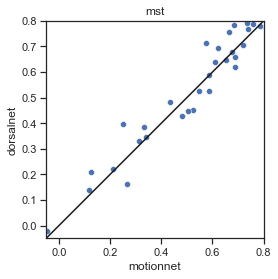

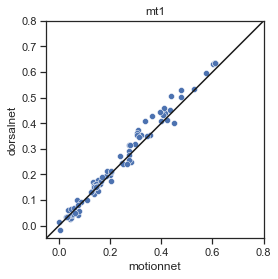

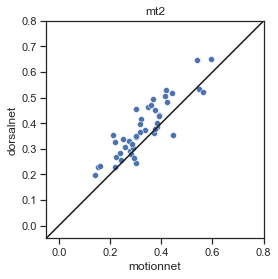

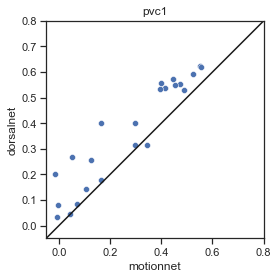

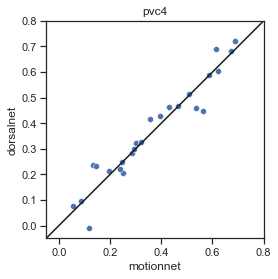

In [6]:
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    best_layer = df_m.idxmax(axis=1)

    good_combos = [f'{x}_{y:02}' for x, y in zip(best_layer.index, best_layer.values)]
    df_ = df_[df_.features_layer.isin(good_combos)]
    df_ = df_.pivot_table('rnorm', 'subset', 'features')
    plt.figure()
    g = sns.scatterplot(x='motionnet', y='dorsalnet', data=df_, ax=plt.gca())
    
    g.plot([-1, 1], [-1, 1], 'k-')
    plt.axis('square')
    g.set_xlim([-.05, .8])
    g.set_ylim([-.05, .8])
    plt.title(dataset)
    
    nbetter = (df_.dorsalnet > df_.motionnet).sum()
    ntotal = df_.shape[0]
    print(f"{dataset}, cells better {nbetter}/{ntotal}")
    

## Pairwise results

In [8]:
"""
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    best_layer = df_m.idxmax(axis=1)

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)
    
    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]
    
    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)
"""

'\ndatasets = df.dataset.unique()\nperf = []\nfor dataset in datasets:\n    df_ = df.query(f\'dataset == "{dataset}"\')\n    df_m = df_.pivot_table(\'rnorm\', \'features\', \'layer\')\n    best_layer = df_m.idxmax(axis=1)\n\n    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)\n    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)\n    \n    series = df_.groupby([\'features_layer\']).mean().report_corr\n    best = series.index[series.argmax()]\n    \n    df_ = pd.merge(df_, df_.query(f\'features_layer == "{best}"\')[[\'subset\', \'rnorm\']], left_on=\'subset\', right_on=\'subset\', suffixes=(\'\', \'_best\'))\n    df_[\'rnorm_delta\'] = df_[\'rnorm\'] - df_[\'rnorm_best\']\n    df_m_delta = df_.pivot_table(\'rnorm_delta\', \'features\', \'layer\')\n    df_s_delta = df_.pivot_table(\'rnorm_delta\', \'features\', \'layer\', aggfunc=\'sem\') + 1e-6\n    df_ = (df_m_delta / df_s_delta).max(axis=1)\n'

# Bump plot

In [10]:
df.dataset.unique()

array(['mst', 'mt1', 'mt2', 'pvc1', 'pvc4'], dtype=object)

In [11]:
dmap = {'mst': 'mst', 'mt1': 'mt', 'mt2': 'mt', 'pvc1': 'v1', 'pvc4': 'v1'}
df['area'] = df.dataset.map(lambda x: dmap[x])
df_ = df.query('features == "dorsalnet"')

df_.groupby(['area', 'layer']).rnorm.mean()

area  layer
mst   0        0.171916
      1        0.307345
      2        0.441059
      3        0.454027
      4        0.447793
      5        0.430787
mt    0        0.145767
      1        0.241011
      2        0.295442
      3        0.291372
      4        0.281236
      5        0.260561
v1    0        0.132205
      1        0.356558
      2        0.361870
      3        0.338111
      4        0.307857
      5        0.275450
Name: rnorm, dtype: float64

/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.1483458333333336
0.16942311181173667
[0.83333333 1.14583333 1.5       ]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.04903937007874
0.1129697681520903
[1.82677165 2.04724409 2.26771654]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.877915625
0.285487171186569
[2.3125 2.875  3.4375]


<Figure size 288x216 with 0 Axes>

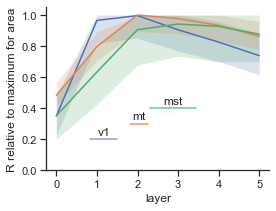

In [66]:
#df_.loc[df_.area == 'v1', 'rnorm_max'] /= .3618
#df_.loc[df_.area == 'mt', 'rnorm_max'] /= .2954
#df_.loc[df_.area == 'mst', 'rnorm_max'] /= .4540

#plt.figure(figsize=(4, 3))
#g = sns.lineplot(x='layer', 
#                y='rnorm_max', 
#                hue='area',
#                palette="Set2",
#                data=df_, legend=False, ax=plt.gca())
#sns.despine()

def bs(df):
    df = df.copy()
    idx = np.random.randint(0, df.shape[0], df.shape[0])
    df_ = df.iloc[idx]
    the_max = df_.groupby(['area', 'layer']).rnorm.mean().groupby('area').max()
    df_ = df_.groupby(['area', 'layer']).rnorm.mean() / the_max
    return df_

dmap = {'pvc1': 'v1', 'pvc4': 'v1', 'mt1': 'mt', 'mt2': 'mt', 'mst': 'mst'}

df['area'] = df.dataset.map(lambda x: dmap[x])
df_ = df.query('features == "dorsalnet"')
df_ = df_.sort_values('area', ascending=True)

df_['rnorm_max'] = df_.rnorm
A = np.array([bs(df_).values for x in range(500)])
df__ = pd.DataFrame(A.T)
df__.index = bs(df_).index
plt.figure(figsize=(4, 3))
#g = sns.lineplot(x='layer', 
#                y='rnorm_max', 
#                hue='area',
#                palette="Set2",
#                data=df_, legend=False, ax=plt.gca())
#np.quantile(A, [.025, .0975], axis=0)
plt.figure(figsize=(4, 3))

for area in ['v1', 'mt', 'mst']:
    vals = np.quantile(df__.loc[area], [.05, .95, .5], axis=1).T
    plt.fill_between(df__.loc[area].index, vals[:, 0], vals[:, 1], alpha=.2)
    plt.plot(df__.loc[area].index, vals[:, 2])
sns.despine()
plt.xlabel('layer')
plt.ylabel('R relative to maximum for area')
plt.yticks([0, .2, .4, .6, .8, 1.0])

cols = sns.color_palette(as_cmap=True)
for i, area in enumerate(['v1', 'mt', 'mst']):
    df_ = df.query(f'report_corr > .01 and features == "dorsalnet" and area == "{area}"')
    df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)
    v = df_.pivot('dataset_subset', 'layer', 'rnorm').values
    
    vals = []
    for n in range(10000):
        v_ = v[np.random.randint(low=0, high=v.shape[0], size=v.shape[0]), :].argmax(axis=1)#mean(axis=0)
        #cs = CubicSpline(np.arange(6), v_)
        #xs = np.linspace(0, 5)
        vals.append(v_.mean())
        
    print(np.mean(vals))
    print(np.std(vals))
    
    q = np.quantile(vals, [.025, .975])
    plt.plot(q, (.2 + .1*i) * np.array([1, 1]), color=g.lines[2-i].get_color())
    plt.text((q[0] + q[1])/2, .225 + .1*i, area, {'ha': 'center'})
    print(np.quantile(vals, [.025, .5, .975]))
    
plt.ylim([0, 1.05])
plt.savefig('/home/pmin/paper-assets/figure-2-layer-alignment.pdf', bbox_inches='tight')

/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.1467666666666667
0.16946478370642873
[0.83333333 1.14583333 1.5       ]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.0495653543307086
0.11325207907842944
[1.82677165 2.04724409 2.27559055]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.87321875
0.28337694191824697
[2.3125  2.875   3.40625]


(0.0, 1.2)

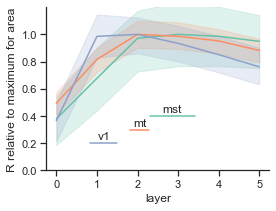

In [12]:
dmap = {'pvc1': 'v1', 'pvc4': 'v1', 'mt1': 'mt', 'mt2': 'mt', 'mst': 'mst'}

df['area'] = df.dataset.map(lambda x: dmap[x])
df_ = df.query('features == "dorsalnet"')
df_ = df_.sort_values('area', ascending=True)

df_['rnorm_max'] = df_.rnorm
df_.loc[df_.area == 'v1', 'rnorm_max'] /= .3618
df_.loc[df_.area == 'mt', 'rnorm_max'] /= .2954
df_.loc[df_.area == 'mst', 'rnorm_max'] /= .4540

plt.figure(figsize=(4, 3))
g = sns.lineplot(x='layer', 
                y='rnorm_max', 
                hue='area',
                palette="Set2",
                data=df_, legend=False, ax=plt.gca())
sns.despine()
#plt.legend(loc='upper right', fancybox=None, frameon=False, bbox_to_anchor=(0.,.3, 1.0, .105))
plt.ylabel('R relative to maximum for area')
plt.yticks([0, .2, .4, .6, .8, 1.0])
cols = sns.color_palette(as_cmap=True)
for i, area in enumerate(['v1', 'mt', 'mst']):
    df_ = df.query(f'report_corr > .01 and features == "dorsalnet" and area == "{area}"')
    df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)
    v = df_.pivot('dataset_subset', 'layer', 'rnorm').values
    
    vals = []
    for n in range(10000):
        v_ = v[np.random.randint(low=0, high=v.shape[0], size=v.shape[0]), :].argmax(axis=1)#mean(axis=0)
        #cs = CubicSpline(np.arange(6), v_)
        #xs = np.linspace(0, 5)
        vals.append(v_.mean())
        
    print(np.mean(vals))
    print(np.std(vals))
    
    q = np.quantile(vals, [.025, .975])
    plt.plot(q, (.2 + .1*i) * np.array([1, 1]), color=g.lines[2-i].get_color())
    plt.text((q[0] + q[1])/2, .225 + .1*i, area, {'ha': 'center'})
    print(np.quantile(vals, [.025, .5, .975]))
    
plt.ylim([0, 1.2])

#plt.savefig('/home/pmin/paper-assets/figure-2-layer-alignment.pdf', bbox_inches='tight')

# Sparse regression

In [73]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": -1},
                     {"config.method": "boosting"},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

Found 1878


100%|███████████████████████████████████████████████████████████| 1878/1878 [00:14<00:00, 131.49it/s]


In [74]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': friendly_name,
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
#df.query('dataset == "mst"').groupby('features_layer').mean()
#df.query('features == "dorsalnet"')
nums

,dataset,features,layer,subset
0,mst,cpc_ucf,0,5
1,mst,cpc_ucf,1,5
2,mst,cpc_ucf,2,5
3,mst,cpc_ucf,4,5
4,mst,cpc_ucf,6,5
5,mst,cpc_ucf,8,5
6,mst,cpc_ucf,10,5
7,mst,dorsalnet,0,36
8,mst,dorsalnet,1,36
9,mst,dorsalnet,2,36


In [76]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)
    
    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]
    
    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

models = ['motionnet', 'dorsalnet']
datasets = ['mt1', 'mt2', 'mst']

df_m = df_m[datasets].loc[models]
df_s = df_s[datasets].loc[models]
df_z = df_z[datasets].loc[models]
    
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 1)}}}\n\\toprule \n"
the_str += '{} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.replace('_', '\_')]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})"[1:])
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")
                
    the_str += ' & '.join(vals) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{llll}
\toprule 
{} & mt1 & mt2 & mst\\
\midrule 
motionnet & .159 (0.012) & .284 (0.012) & .361 (0.048)\\
dorsalnet & \textbf{0.228} (0.017) & \textbf{0.370} (0.016) & \textbf{0.474} (0.051)\\
\end{tabular}



In [70]:
import scipy.stats
zvals = pd.DataFrame(2*scipy.stats.norm.cdf(df_z))
zvals.columns = df_z.columns
zvals.index = df_z.index
zvals

dataset,mt2,mst
features,,
motionnet,5.483787e-19,1.114343e-09
dorsalnet,1.000000e+00,1.000000e+00


mst, cells better 31/36
mt2, cells better 40/44


ValueError: Could not interpret value `motionnet` for parameter `x`

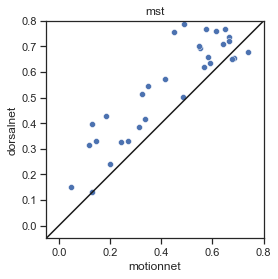

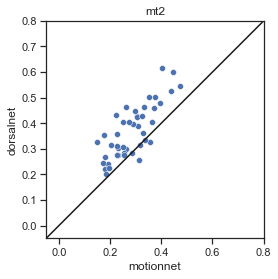

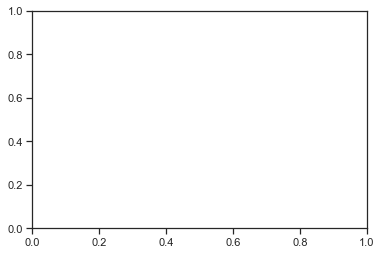

In [71]:
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    best_layer = df_m.idxmax(axis=1)

    good_combos = [f'{x}_{y:02}' for x, y in zip(best_layer.index, best_layer.values)]
    df_ = df_[df_.features_layer.isin(good_combos)]
    df_ = df_.pivot_table('rnorm', 'subset', 'features')
    plt.figure()
    g = sns.scatterplot(x='motionnet', y='dorsalnet', data=df_, ax=plt.gca())
    
    g.plot([-1, 1], [-1, 1], 'k-')
    plt.axis('square')
    g.set_xlim([-.05, .8])
    g.set_ylim([-.05, .8])
    plt.title(dataset)
    
    nbetter = (df_.dorsalnet > df_.motionnet).sum()
    ntotal = df_.shape[0]
    print(f"{dataset}, cells better {nbetter}/{ntotal}")
    

# Present CKA results

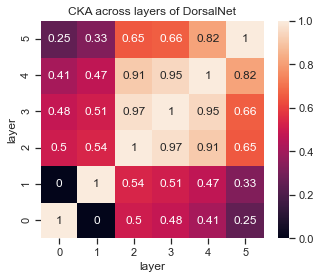

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

A = np.load('../cka.npy')
plt.figure(figsize=(5, 4))
f = sns.heatmap(A[:-1, :-1], annot=True)
plt.xlabel('layer')
plt.ylabel('layer')
plt.title('CKA across layers of DorsalNet')
plt.ylim([0, 6])
plt.savefig('../revision/cka.pdf')

# Resizing results

In [9]:
import collections
import numpy as np
import pickle
import torch
from tqdm import tqdm
import wandb

import sys
sys.path.append('../')
import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from python_dict_wrapper import wrap
import torch
import seaborn as sns

import matplotlib

matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(font="Arial", style="ticks")

In [10]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

KeyboardInterrupt: 

In [ ]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
        
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': friendly_name,
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'scale': round((sz / 112) * 100) / 100,
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer', 'scale']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer', 'scale'), right_on=('dataset', 'features', 'layer', 'scale'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
#df.query('dataset == "mst"').groupby('features_layer').mean()
#df.query('features == "dorsalnet"')
nums

In [121]:
df.query(f'features == "dorsalnet" and scale == "{ratio}"')

,key,family,dataset,subset,features,layer,features_layer,report_corr,max_r2,scale,rnorm,subset_overall,area


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.0011166666666667
0.15274020108595437
[0.72916667 1.         1.3125    ]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.913296850393701
0.1011542206117604
[1.71653543 1.91338583 2.11023622]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.47130625
0.2708120542201501
[1.9375  2.46875 3.     ]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.1438562500000002
0.17090305232578742
[0.83333333 1.14583333 1.5       ]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.047892125984252
0.11169005508708828
[1.82677165 2.04724409 2.26771654]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.877034375
0.2878897867016289
[2.3125 2.875  3.4375]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.3222297872340425
0.1978943398431716
[0.95744681 1.31914894 1.72340426]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.078377952755906
0.11134512114804138
[1.86594488 2.07874016 2.2992126 ]


/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/pmin/anaconda3/envs/head/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2.63271
0.24921777694306727
[2.13333333 2.63333333 3.10083333]


<Figure size 288x216 with 0 Axes>

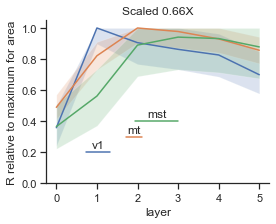

<Figure size 288x216 with 0 Axes>

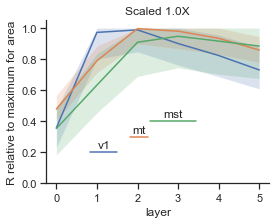

<Figure size 288x216 with 0 Axes>

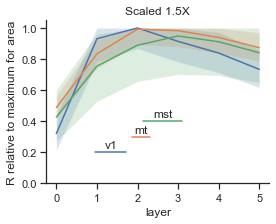

In [ ]:
#df_.loc[df_.area == 'v1', 'rnorm_max'] /= .3618
#df_.loc[df_.area == 'mt', 'rnorm_max'] /= .2954
#df_.loc[df_.area == 'mst', 'rnorm_max'] /= .4540

#plt.figure(figsize=(4, 3))
#g = sns.lineplot(x='layer', 
#                y='rnorm_max', 
#                hue='area',
#                palette="Set2",
#                data=df_, legend=False, ax=plt.gca())
#sns.despine()

for ratio in [0.66, 1.0, 1.5]:
    def bs(df):
        df = df.copy()
        idx = np.random.randint(0, df.shape[0], df.shape[0])
        df_ = df.iloc[idx]
        the_max = df_.groupby(['area', 'layer']).rnorm.mean().groupby('area').max()
        df_ = df_.groupby(['area', 'layer']).rnorm.mean() / the_max
        return df_

    dmap = {'pvc1': 'v1', 'pvc4': 'v1', 'mt1': 'mt', 'mt2': 'mt', 'mst': 'mst'}

    df['area'] = df.dataset.map(lambda x: dmap[x])
    df_ = df.query(f'features == "dorsalnet" and scale == {ratio}')
    df_ = df_.sort_values('area', ascending=True)

    df_['rnorm_max'] = df_.rnorm
    A = np.array([bs(df_).values for x in range(500)])
    df__ = pd.DataFrame(A.T)
    df__.index = bs(df_).index
    plt.figure(figsize=(4, 3))
    #g = sns.lineplot(x='layer', 
    #                y='rnorm_max', 
    #                hue='area',
    #                palette="Set2",
    #                data=df_, legend=False, ax=plt.gca())
    #np.quantile(A, [.025, .0975], axis=0)
    plt.figure(figsize=(4, 3))

    lines = []
    for area in ['v1', 'mt', 'mst']:
        vals = np.quantile(df__.loc[area], [.05, .95, .5], axis=1).T
        plt.fill_between(df__.loc[area].index, vals[:, 0], vals[:, 1], alpha=.2)
        lines.append(plt.plot(df__.loc[area].index, vals[:, 2]))
    sns.despine()
    plt.xlabel('layer')
    plt.ylabel('R relative to maximum for area')
    plt.yticks([0, .2, .4, .6, .8, 1.0])

    cols = sns.color_palette(as_cmap=True)
    for i, area in enumerate(['v1', 'mt', 'mst']):
        df_ = df.query(f'report_corr > .01 and features == "dorsalnet" and area == "{area}" and scale == {ratio}')
        df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)
        v = df_.pivot('dataset_subset', 'layer', 'rnorm').values

        vals = []
        for n in range(10000):
            v_ = v[np.random.randint(low=0, high=v.shape[0], size=v.shape[0]), :].argmax(axis=1)#mean(axis=0)
            #cs = CubicSpline(np.arange(6), v_)
            #xs = np.linspace(0, 5)
            vals.append(v_.mean())

        print(np.mean(vals))
        print(np.std(vals))

        q = np.quantile(vals, [.025, .975])
        plt.plot(q, (.2 + .1*i) * np.array([1, 1]), color=lines[i][0].get_color())
        plt.text((q[0] + q[1])/2, .225 + .1*i, area, {'ha': 'center'})
        print(np.quantile(vals, [.025, .5, .975]))

    plt.ylim([0, 1.05])
    plt.title(f'Scaled {ratio}X')
    
    plt.savefig(f'/home/pmin/paper-assets/figure-2-layer-alignment-rescaled-{ratio}.pdf', bbox_inches='tight')
    plt.savefig(f'/home/pmin/paper-assets/figure-2-layer-alignment-rescaled-{ratio}.png', bbox_inches='tight')

In [ ]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()

for ratio in [0.66, 1.0, 1.5]:
    perf = []
    for dataset in datasets:
        df_ = df.query(f'dataset == "{dataset}" and scale == {ratio}')
        df_m = df_.pivot_table('rnorm', 'features', 'layer')
        df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

        m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
        s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

        series = df_.groupby(['features_layer']).mean().report_corr
        best = series.index[series.argmax()]

        df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
        df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
        df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
        df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
        df_ = (df_m_delta / df_s_delta).max(axis=1)

        perf += [{'dataset': dataset, 
                  'features': f, 
                  'z': df_.loc[f],
                  'm': mm, 
                  's': ss} for f, mm, ss in zip(df_m.index, m, s)]

    df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
    df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
    df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

    models = ['motionnet', 'dorsalnet']
    datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

    df_m = df_m[datasets].loc[models]
    df_s = df_s[datasets].loc[models]
    df_z = df_z[datasets].loc[models]

    the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 1)}}}\n\\toprule \n"
    the_str += '{} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
    the_str += '\midrule \n'

    for idx, row in df_m.iterrows():
        vals = [idx.replace('_', '\_')]
        for feature, v in row.items():
            if np.isnan(v):
                vals.append('-')
            else:
                if df_z.loc[idx, feature].item() < -1.96:
                    vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
                else:
                    vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

        the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

    the_str += "\end{tabular}\n"
    print(the_str)

# Resizing, with regression

In [68]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/6119 [00:00<?, ?it/s]

Found 6119


100%|██████████| 6119/6119 [01:10<00:00, 87.27it/s] 


In [69]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
#df.query('dataset == "mst"').groupby('features_layer').mean()
#df.query('features == "dorsalnet"')
nums

,dataset,features,layer,subset
0,mst,dorsalnet_0.66,0,36
1,mst,dorsalnet_0.66,1,36
2,mst,dorsalnet_0.66,2,36
3,mst,dorsalnet_0.66,3,36
4,mst,dorsalnet_0.66,4,36
...,...,...,...,...
115,pvc4,motionnet_0.66,1,25
116,pvc4,motionnet_1.00,0,25
117,pvc4,motionnet_1.00,1,25
118,pvc4,motionnet_1.50,0,25


In [72]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

#models = ['motionnet', 'dorsalnet']
#datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets]#.loc[models]
df_s = df_s[datasets]#.loc[models]
df_z = df_z[datasets]#.loc[models]

In [73]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
#print(f"Ratio: {ratio}")
print(the_str)

\begin{tabular}{lllllll}
\toprule 
{scaling} & {model} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & \textbf{.358} (.041) & \textbf{.380} (.040) & .245 (.018) & \textbf{.388} (.016) & \textbf{.460} (.056)\\
dorsalnet & 1.00 & \textbf{.364} (.043) & \textbf{.370} (.039) & \textbf{.251} (.019) & \textbf{.381} (.017) & \textbf{.454} (.054)\\
dorsalnet & 1.50 & \textbf{.389} (.034) & \textbf{.359} (.038) & \textbf{.252} (.020) & .370 (.017) & .411 (.052)\\
motionnet & .66 & .303 (.044) & \textbf{.373} (.041) & .221 (.018) & .306 (.016) & .403 (.052)\\
motionnet & 1.00 & .276 (.042) & \textbf{.364} (.039) & .238 (.018) & .333 (.016) & \textbf{.441} (.053)\\
motionnet & 1.50 & \textbf{.343} (.040) & \textbf{.371} (.039) & \textbf{.252} (.019) & .346 (.016) & \textbf{.452} (.050)\\
\end{tabular}



# Resizing, with boosting

In [60]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.method": "boosting"},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/4042 [00:00<?, ?it/s]

Found 4042


100%|██████████| 4042/4042 [00:36<00:00, 111.27it/s]


In [64]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
#df.query('dataset == "mst"').groupby('features_layer').mean()
#df.query('features == "dorsalnet"')
nums

,dataset,features,layer,subset
0,mst,dorsalnet_0.66,0,36
1,mst,dorsalnet_0.66,1,36
2,mst,dorsalnet_0.66,2,36
3,mst,dorsalnet_0.66,3,36
4,mst,dorsalnet_0.66,4,36
5,mst,dorsalnet_0.66,5,36
6,mst,dorsalnet_1.00,0,36
7,mst,dorsalnet_1.00,1,36
8,mst,dorsalnet_1.00,2,36
9,mst,dorsalnet_1.00,3,36


In [66]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
datasets = ['mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

#models = ['motionnet', 'dorsalnet']
#datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets]#.loc[models]
df_s = df_s[datasets]#.loc[models]
df_z = df_z[datasets]#.loc[models]

In [67]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
#print(f"Ratio: {ratio}")
print(the_str)

\begin{tabular}{lllll}
\toprule 
{scaling} & {model} & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & - & - & \textbf{.464} (.054)\\
dorsalnet & 1.00 & \textbf{.228} (.017) & \textbf{.370} (.016) & \textbf{.474} (.051)\\
dorsalnet & 1.50 & \textbf{.230} (.017) & .362 (.016) & .434 (.051)\\
motionnet & .66 & - & - & .336 (.050)\\
motionnet & 1.00 & .159 (.012) & .284 (.012) & .361 (.048)\\
motionnet & 1.50 & .160 (.011) & .298 (.012) & .385 (.047)\\
\end{tabular}



# Resizing, with boosting

In [60]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.method": "boosting"},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/4042 [00:00<?, ?it/s]

Found 4042


100%|██████████| 4042/4042 [00:36<00:00, 111.27it/s]


In [64]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
#df.query('dataset == "mst"').groupby('features_layer').mean()
#df.query('features == "dorsalnet"')
nums

,dataset,features,layer,subset
0,mst,dorsalnet_0.66,0,36
1,mst,dorsalnet_0.66,1,36
2,mst,dorsalnet_0.66,2,36
3,mst,dorsalnet_0.66,3,36
4,mst,dorsalnet_0.66,4,36
5,mst,dorsalnet_0.66,5,36
6,mst,dorsalnet_1.00,0,36
7,mst,dorsalnet_1.00,1,36
8,mst,dorsalnet_1.00,2,36
9,mst,dorsalnet_1.00,3,36


In [66]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
datasets = ['mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

#models = ['motionnet', 'dorsalnet']
#datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets]#.loc[models]
df_s = df_s[datasets]#.loc[models]
df_z = df_z[datasets]#.loc[models]

In [67]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
#print(f"Ratio: {ratio}")
print(the_str)

\begin{tabular}{lllll}
\toprule 
{scaling} & {model} & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & - & - & \textbf{.464} (.054)\\
dorsalnet & 1.00 & \textbf{.228} (.017) & \textbf{.370} (.016) & \textbf{.474} (.051)\\
dorsalnet & 1.50 & \textbf{.230} (.017) & .362 (.016) & .434 (.051)\\
motionnet & .66 & - & - & .336 (.050)\\
motionnet & 1.00 & .159 (.012) & .284 (.012) & .361 (.048)\\
motionnet & 1.50 & .160 (.011) & .298 (.012) & .385 (.047)\\
\end{tabular}



In [14]:
df.query('dataset == "mt2"').groupby(['features', 'layer', 'scale']).first()

key      family dataset  \
features  layer scale                                                    
dorsalnet 0     1.0    airsim_04_layer00_mt2_0_112  dorsalnets     mt2   
          1     1.0    airsim_04_layer01_mt2_0_112  dorsalnets     mt2   
          2     1.0    airsim_04_layer02_mt2_0_112  dorsalnets     mt2   
          3     1.0    airsim_04_layer03_mt2_0_112  dorsalnets     mt2   
          4     1.0    airsim_04_layer04_mt2_0_112  dorsalnets     mt2   
          5     1.0    airsim_04_layer05_mt2_0_112  dorsalnets     mt2   
motionnet 0     1.0    MotionNet_layer00_mt2_0_112     control     mt2   
          1     1.0    MotionNet_layer01_mt2_0_112     control     mt2   

                       subset features_layer  report_corr  max_r2     rnorm  \
features  layer scale                                                         
dorsalnet 0     1.0         0   dorsalnet_00     0.043638     1.0  0.043638   
          1     1.0         0   dorsalnet_01     0.140126     1.0  0.140126   
          2     1.0         0   dorsalnet_02     0.242174     1.0  0.242174   
          3     1.0         0   dorsalnet_03     0.233847     1.0  0.233847   
          4     1.0         0   dorsalnet_04     0.223061     1.0  0.223061   
          5     1.0         0   dorsalnet_05     0.177089     1.0  0.177089   
motionnet 0     1.0         0   motionnet_00     0.157166     1.0  0.157166   
          1     1.0         0   motionnet_01     0.192592     1.0  0.192592   

                       subset_overall  
features  layer scale                  
dorsalnet 0     1.0                44  
          1     1.0                44  
          2     1.0                44  
          3     1.0                44  
          4     1.0                44  
          5     1.0                44  
motionnet 0     1.0                44  
          1     1.0                44

In [11]:
# Boosting results, version 2

In [12]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample_t"},
                     {"config.method": "boosting"},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/5084 [00:00<?, ?it/s]

Found 5084


100%|██████████| 5084/5084 [00:45<00:00, 111.84it/s]


In [52]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses nothing
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
#df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
#df.query('dataset == "mst"').groupby('features_layer').mean()
#df.query('features == "dorsalnet"')
#nums.query('dataset == "mst"')
#df.query('dataset == "mt2" and layer == 1 and features == "motionnet" and scale == 1.5')

In [55]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

#models = ['motionnet', 'dorsalnet']
#datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets]#.loc[models]
df_s = df_s[datasets]#.loc[models]
df_z = df_z[datasets]#.loc[models]

In [56]:
df_m

dataset,pvc1,pvc4,mt1,mt2,mst
features,,,,,
dorsalnet_0.66,0.471455,0.354985,0.211944,0.352661,0.434801
dorsalnet_1.00,0.490741,0.312732,0.217407,0.348335,0.415224
dorsalnet_1.50,0.502507,0.312602,0.208560,0.328236,0.356430
motionnet_0.66,0.370516,0.318726,0.157348,0.257741,0.345064
motionnet_1.00,0.425646,0.310855,0.158347,0.270940,0.358728
motionnet_1.50,0.459929,0.313430,0.157763,0.282041,0.364690


In [59]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
#print(f"Ratio: {ratio}")
print(the_str)

\begin{tabular}{lllllll}
\toprule 
{scaling} & {model} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & .471 (.051) & \textbf{.355} (.038) & .212 (.016) & \textbf{.353} (.016) & \textbf{.435} (.052)\\
dorsalnet & 1.00 & \textbf{.491} (.049) & .313 (.039) & \textbf{.217} (.016) & \textbf{.348} (.016) & \textbf{.415} (.055)\\
dorsalnet & 1.50 & \textbf{.503} (.051) & \textbf{.313} (.034) & .209 (.016) & .328 (.016) & .356 (.052)\\
motionnet & .66 & .371 (.048) & \textbf{.319} (.036) & .157 (.012) & .258 (.013) & .345 (.049)\\
motionnet & 1.00 & .426 (.050) & \textbf{.311} (.034) & .158 (.012) & .271 (.012) & .359 (.048)\\
motionnet & 1.50 & \textbf{.460} (.051) & .313 (.036) & .158 (.012) & .282 (.012) & .365 (.047)\\
\end{tabular}

